# Text mining and search exam notebook: Papers Preprocessing
Authors: Gaetano Chiriaco, Riccardo Porcedda, Gianmarco Russo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Import papers
papers = pd.read_csv("drive/MyDrive/TM&S/data/papers.csv")

#Extract Abstract and Main Text

In [ ]:
papers.head(3)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...


In [ ]:
papers.paper_text[0]

'767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABASE\nAND ITS APPLICATIONS\nHisashi Suzuki and Suguru Arimoto\nOsaka University, Toyonaka, Osaka 560, Japan\nABSTRACT\nAn efficient method of self-organizing associative databases is proposed together with\napplications to robot eyesight systems. The proposed databases can associate any input\nwith some output. In the first half part of discussion, an algorithm of self-organization is\nproposed. From an aspect of hardware, it produces a new style of neural network. In the\nlatter half part, an applicability to handwritten letter recognition and that to an autonomous\nmobile robot system are demonstrated.\n\nINTRODUCTION\nLet a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another\nfinite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly\nfrom X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some\nestimate j : X -+ Y of f to make small, the estimation erro

In [ ]:
len(papers)

7241

## Where are the words "abstract", "introduction" and "references" located?

In [ ]:
import re
import numpy as np

def get_word_position(word: str, text: str, take="first") -> float:

  valid_take={"first","last"}
  if take not in valid_take:
    raise ValueError("'take' must be one of %r." % valid_take)

  #remove linebreaks
  text = text.replace("\n"," ")

  try:
    #If both upper and capitalize are present, consider the first/last one (indicated by take)
    a = re.search(r"\b%s\b" % word.upper(), text).start()/len(text)
    b = re.search(r"\b%s\b" % word.capitalize(), text).start()/len(text)

    if take=="first":
      return min([a,b])
    elif take=="last":
      return max([a,b])

  except AttributeError:
    try:
      return re.search(r"\b%s\b" % word.upper(), text).start()/len(text)
    except AttributeError:
      try:
        return re.search(r"\b%s\b" % word.capitalize(), text).start()/len(text)
      except AttributeError:
        return -1

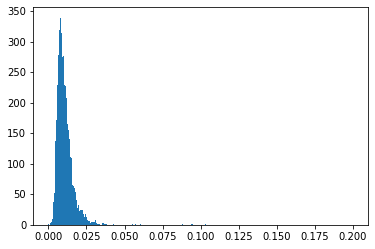

In [ ]:
import matplotlib.pyplot as plt

# Relative position of the term "abstract"
hist1 = plt.hist(papers["paper_text"].apply(lambda x: get_word_position("abstract",x)),bins=500,range=(0,0.2))
plt.show()

In [ ]:
# Compute the quantile
abs_quant = np.quantile(papers["paper_text"].apply(lambda x: get_word_position("abstract",x)),0.95)
abs_quant

0.020143429656190676

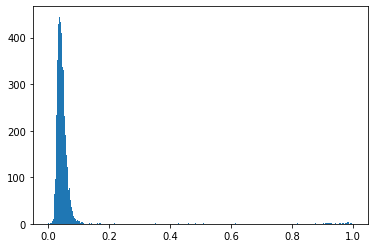

In [ ]:
# Relative position of the term "introduction"
hist2 = plt.hist(papers["paper_text"].apply(lambda x: get_word_position("introduction",x)),bins=500,range=(0,1))
plt.show()

In [ ]:
# Compute the quantile
intro_quant = np.quantile(papers["paper_text"].apply(lambda x: get_word_position("introduction",x)),0.95)
intro_quant

0.0713353115727003

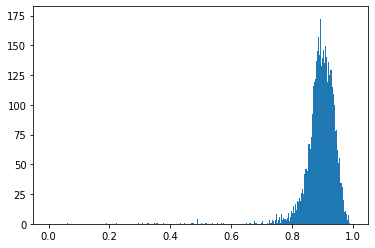

In [ ]:
# Relative position of the term "references"
hist3 = plt.hist(papers["paper_text"].apply(lambda x: get_word_position("references",x,take="last")),bins=500,range=(0,1))
plt.show()

In [ ]:
# Compute the quantile
ref_quant = np.quantile(papers["paper_text"].apply(lambda x: get_word_position("references",x)),0.05)
ref_quant

0.8056631324995238

## Use the quantiles

In [ ]:
# Get first/last term occurence and its relative position
def get_word_and_position(word: str, text: str, take="first"):

  valid_take={"first","last"}
  if take not in valid_take:
    raise ValueError("'take' must be one of %r." % valid_take)

  #remove linebreaks
  text = text.replace("\n"," ")

  try:
    #If both upper and capitalize are present, consider the first/last one (indicated by take)
    a = re.search(r"\b%s\b" % word.upper(), text)
    b = re.search(r"\b%s\b" % word.capitalize(), text)
    
    if take=="first":
      if a.start()/len(text) < b.start()/len(text):
        return a.group(), a.start()/len(text)
      else:
        return b.group(), b.start()/len(text)

    elif take=="last":
      if a.start()/len(text) > b.start()/len(text):
        return a.group(), a.start()/len(text)
      else:
        return b.group(), b.start()/len(text)

  except AttributeError:
    try:
      a = re.search(r"\b%s\b" % word.upper(), text)
      return a.group(), a.start()/len(text)
    except AttributeError:
      try:
        a = re.search(r"\b%s\b" % word.capitalize(), text)
        return a.group(), a.start()/len(text)
      except AttributeError:
        return "no match", -1

In [ ]:
#TEST

get_word_and_position("introduction","This is an introduction where we use the words Introduction and INTRODUCTION")

('Introduction', 0.618421052631579)

In [ ]:
get_word_and_position("introduction","This is an introduction where we use the words INTRODUCTION and INTRODUCTION")

('INTRODUCTION', 0.618421052631579)

In [ ]:
get_word_and_position("references","Should take not the first REFERENCES, but the last References",take="last")

('References', 0.8360655737704918)

In [ ]:
# Extract main text and abstract using keywords and relative chosen quantiles
def clean_extract(text: str, abs: str, intro: str, ref: str) -> str:

  #remove linebreaks
  text = text.replace("\n"," ")

  #get keywords and their position, if present
  intro, intro_pos = get_word_and_position(intro,text)
  abs, abs_pos = get_word_and_position(abs,text)
  ref, ref_pos = get_word_and_position(ref,text,take="last")

  #Check intro position
  if intro=="no match" or intro_pos > intro_quant:
    ab = "Abstract Missing"
    main = "no match"
    return ab, main

  #If position is ok, continue
  else:
    #Check abstract position
    if abs!="no match" and abs_pos < abs_quant:
      #extract abstract
      try:
        ab = re.search('%s(.*?)%s' % (abs, intro), text).group(1)
      except AttributeError:
        print(intro+" found before "+abs)
        ab = "Abstract Missing"
        main = "no match"
        return ab, main
    else:
      ab = "Abstract Missing"

    #If references position is ok, main text is between intro and ref
    if ref!="no match" and ref_pos > ref_quant:
      main = re.search('%s(.*)%s' % (intro, ref), text).group(1)
    #otherwise main text is everything after intro
    else:
      main = re.search('%s(.*)' % intro, text).group(1)
      print("References not found")

    return ab, main

In [ ]:
papers["Abstract"]=papers["abstract"]
papers["Main"]=papers["paper_text"]

for i in range(len(papers)):
  papers["Abstract"][i], papers["Main"][i] = clean_extract(papers["paper_text"][i], "abstract", "introduction", "references")

<ipython-input-17-5ecf13c3305d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papers["Abstract"][i], papers["Main"][i] = clean_extract(papers["paper_text"][i], "abstract", "introduction", "references")


References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References not found
References no

In [ ]:
# Number of papers where extraction of main text failed
len(papers["Main"][papers["Main"]=="no match"])

866

In [ ]:
# Where Abstract was missing in the original column, insert the extracted abstract if present
papers["abstract"][papers["abstract"]=="Abstract Missing"]=papers["Abstract"]

<ipython-input-21-45066019a5d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papers["abstract"][papers["abstract"]=="Abstract Missing"]=papers["Abstract"]


In [ ]:
# Number of papers where extraction of abstract failed
len(papers["abstract"][papers["abstract"]=="Abstract Missing"])

910

In [ ]:
# Drop not useful columns
papers.drop(["id","year","paper_text","event_type","pdf_name","Abstract"], axis=1, inplace=True)

In [ ]:
# Drop papers with main text or abstract missing
papers = papers[(papers["Main"]!="no match") & (papers["abstract"]!="Abstract Missing")]
len(papers)

6194

In [ ]:
papers.head()

,title,abstract,Main
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"Let a mapping f : X -+ Y be given. Here, X is..."
3,Bayesian Query Construction for Neural Network...,"If data collection is costly, there is much t...",In this paper we consider the situation wher...
4,"Neural Network Ensembles, Cross Validation, an...",Learning of continuous valued functions using...,It is well known that a combination of many ...
9,Pulsestream Synapses with Non-Volatile Analogu...,This paper presents results from the first us...,Fusion of the nuclei of hydrogen provides th...
10,Learning to Play the Game of Chess,"This paper presents NeuroChess, a program whi...","Throughout the last decades, the game of ches..."


In [ ]:
papers.to_csv("drive/MyDrive/TM&S/data/abs_and_main.csv", index=False)

#Preprocess

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def remove_punctuation(text):
    # String punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def character_repetition(text):
    # Pattern matching for all case alphabets
    # \1   It refers to the first capturing group.
    # {1,} It means we are matching for repetition that occurs more than one time.
    # r’\1\1' → It limits all the repetition to two characters.
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    return Formatted_text

def remove_spaces(text):
    return text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('  ', ' ').replace('\n\n',' ')


def remove_stopwords(tokenized_text):
  stop_words = stopwords.words('english')
  tokenized_text_without_stopwords = []
  for token in tokenized_text:
    if token.lower() not in stop_words and len(token)>2:
      tokenized_text_without_stopwords.append(token)
  return tokenized_text_without_stopwords


def lemmatization(tokenized_text):
  wnl = WordNetLemmatizer()
  n_words = len(tokenized_text)
  for idx in range(n_words):
    tokenized_text[idx] = wnl.lemmatize(tokenized_text[idx])
  return tokenized_text


def stemming(tokenized_text):
    stemmer = SnowballStemmer("english")
    n_words = len(tokenized_text)
    for idx in range(n_words):
      tokenized_text[idx] = stemmer.stem(tokenized_text[idx])
    return tokenized_text
    

def preprocess(text,stopword = True, lemma = True,stem=False):
  tokenized_text =  WordPunctTokenizer().tokenize(text)
  if stopword:
    tokenized_text = remove_stopwords(tokenized_text)
  
  if lemma:
    tokenized_text = lemmatization(tokenized_text)
  
  if stem:
    tokenized_text = stemming(tokenized_text)

  return tokenized_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df = pd.read_csv("drive/MyDrive/TM&S/data/abs_and_main.csv")

In [ ]:
df.head()

,title,abstract,Main
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"Let a mapping f : X -+ Y be given. Here, X is..."
1,Bayesian Query Construction for Neural Network...,"If data collection is costly, there is much t...",In this paper we consider the situation wher...
2,"Neural Network Ensembles, Cross Validation, an...",Learning of continuous valued functions using...,It is well known that a combination of many ...
3,Pulsestream Synapses with Non-Volatile Analogu...,This paper presents results from the first us...,Fusion of the nuclei of hydrogen provides th...
4,Learning to Play the Game of Chess,"This paper presents NeuroChess, a program whi...","Throughout the last decades, the game of ches..."


## Abstract

In [ ]:
abs_sent=df[["title","abstract"]]
abs_sent.head()

,title,abstract
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...
1,Bayesian Query Construction for Neural Network...,"If data collection is costly, there is much t..."
2,"Neural Network Ensembles, Cross Validation, an...",Learning of continuous valued functions using...
3,Pulsestream Synapses with Non-Volatile Analogu...,This paper presents results from the first us...
4,Learning to Play the Game of Chess,"This paper presents NeuroChess, a program whi..."


In [ ]:
#Subset abstracts into sentences 
abs_sent["sentences"] = abs_sent["abstract"].apply(lambda x: sent_tokenize(x))

In [ ]:
abs_sent = abs_sent.explode(column=["sentences"],ignore_index=True)
abs_sent

,title,abstract,sentences
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,An efficient method of self-organizing associ...
1,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,The proposed databases can associate any input...
2,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the first half part of discussion, an algor..."
3,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"From an aspect of hardware, it produces a new ..."
4,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the latter half part, an applicability to h..."
...,...,...,...
39475,Correlation and Interpolation Networks for Rea...,We describe a framework for real-time trackin...,A distributed view-based representation is use...
39476,Correlation and Interpolation Networks for Rea...,We describe a framework for real-time trackin...,The ensemble response of the set of view corre...
39477,Correlation and Interpolation Networks for Rea...,We describe a framework for real-time trackin...,Activation levels of the motor state correspon...
39478,Correlation and Interpolation Networks for Rea...,We describe a framework for real-time trackin...,By integrating fast and robust 2-D processing ...


In [ ]:
# Preprocess sentences
abs_sent["clean_sent"] = abs_sent["sentences"].apply(lambda x: remove_punctuation(x))
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(lambda x: x.lower())
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(lambda x: re.sub(r'\d+', '', x))
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(lambda x: character_repetition(x))
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(lambda x: remove_spaces(x))
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(lambda x: preprocess(x))

In [ ]:
abs_sent.head()

,title,abstract,sentences,clean_sent
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,An efficient method of self-organizing associ...,"[efficient, method, selforganizing, associativ..."
1,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,The proposed databases can associate any input...,"[proposed, database, associate, input, output]"
2,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the first half part of discussion, an algor...","[first, half, part, discussion, algorithm, sel..."
3,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"From an aspect of hardware, it produces a new ...","[aspect, hardware, produce, new, style, neural..."
4,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the latter half part, an applicability to h...","[latter, half, part, applicability, handwritte..."


In [ ]:
# Compute sentence length
abs_sent["sent_len"] = abs_sent["clean_sent"].apply(lambda x: len(x))
abs_sent.head()

,title,abstract,sentences,clean_sent,sent_len
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,An efficient method of self-organizing associ...,"[efficient, method, selforganizing, associativ...",11
1,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,The proposed databases can associate any input...,"[proposed, database, associate, input, output]",5
2,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the first half part of discussion, an algor...","[first, half, part, discussion, algorithm, sel...",7
3,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"From an aspect of hardware, it produces a new ...","[aspect, hardware, produce, new, style, neural...",7
4,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"In the latter half part, an applicability to h...","[latter, half, part, applicability, handwritte...",12


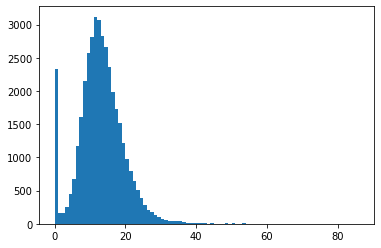

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Show distribution of sentences length in the abstracts
hist_len = plt.hist(abs_sent["sent_len"],bins=np.max(abs_sent["sent_len"]))
plt.show()

In [ ]:
#We will use this value to filter out sentences in the main text which are not relevant
max_len = np.max(abs_sent["sent_len"])
max_len

86

In [ ]:
#Filter out sentences with less than 3 tokens
abs_sent = abs_sent[abs_sent["sent_len"]>2]

In [ ]:
#Get relative position of every sentence in its belonging document
abs_sent["sent_pos"] = (abs_sent.groupby("title",sort=False).cumcount() + 1).astype(float)
abs_sent["total_length"] = 0.
abs_sent = abs_sent.join(abs_sent.groupby("title",sort=False)["total_length"].size(), on="title", rsuffix='_r')

abs_sent["sent_pos"] = abs_sent["sent_pos"] / abs_sent["total_length_r"]

abs_sent.drop(["total_length","total_length_r"],axis=1,inplace=True)

<ipython-input-41-af72f580c685>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_sent["sent_pos"] = (abs_sent.groupby("title",sort=False).cumcount() + 1).astype(float)
<ipython-input-41-af72f580c685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_sent["total_length"] = 0.


In [ ]:
# Drop the abstract column (we already have all sentences exploded)
abs_sent.drop(["abstract"],axis=1,inplace=True)
abs_sent.columns

Index(['title', 'sentences', 'clean_sent', 'sent_len', 'sent_pos'], dtype='object')

In [ ]:
abs_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"[efficient, method, selforganizing, associativ...",11,0.2
1,Self-Organization of Associative Database and ...,The proposed databases can associate any input...,"[proposed, database, associate, input, output]",5,0.4
2,Self-Organization of Associative Database and ...,"In the first half part of discussion, an algor...","[first, half, part, discussion, algorithm, sel...",7,0.6
3,Self-Organization of Associative Database and ...,"From an aspect of hardware, it produces a new ...","[aspect, hardware, produce, new, style, neural...",7,0.8
4,Self-Organization of Associative Database and ...,"In the latter half part, an applicability to h...","[latter, half, part, applicability, handwritte...",12,1.0


In [ ]:
abs_sent.to_csv("drive/MyDrive/TM&S/data/abs_features.csv", index=False)

## Main text

In [ ]:
main_sent=df[["title","Main"]]
main_sent.head()

,title,Main
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is..."
1,Bayesian Query Construction for Neural Network...,In this paper we consider the situation wher...
2,"Neural Network Ensembles, Cross Validation, an...",It is well known that a combination of many ...
3,Pulsestream Synapses with Non-Volatile Analogu...,Fusion of the nuclei of hydrogen provides th...
4,Learning to Play the Game of Chess,"Throughout the last decades, the game of ches..."


In [ ]:
# Subset main text into sentences
main_sent["sentences"] = main_sent["Main"].apply(lambda x: sent_tokenize(x))

In [ ]:
main_sent = main_sent.explode(column=["sentences"],ignore_index=True)
main_sent

,title,Main,sentences
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",Let a mapping f : X -+ Y be given.
1,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","Here, X is a finite or infinite set, and Y is ..."
2,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",A learning machine observes any set of pairs (...
3,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",(X x Y means the Cartesian product of X and Y.)
4,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","And, it computes some estimate j : X -+ Y of f..."
...,...,...,...
1947687,Correlation and Interpolation Networks for Rea...,An important task for natural and artificial ...,A distributed view-based representation is com...
1947688,Correlation and Interpolation Networks for Rea...,An important task for natural and artificial ...,3-D constraints on facial shape are achieved t...
1947689,Correlation and Interpolation Networks for Rea...,An important task for natural and artificial ...,With this framework we have been able to achei...
1947690,Correlation and Interpolation Networks for Rea...,An important task for natural and artificial ...,A modeled face mimics the expression of a user...


In [ ]:
# Preprocess (same as for abstracts)
main_sent["clean_sent"] = main_sent["sentences"].apply(lambda x: remove_punctuation(x))
main_sent["clean_sent"] = main_sent["clean_sent"].apply(lambda x: x.lower())
main_sent["clean_sent"] = main_sent["clean_sent"].apply(lambda x: re.sub(r'\d+', '', x))
main_sent["clean_sent"] = main_sent["clean_sent"].apply(lambda x: character_repetition(x))
main_sent["clean_sent"] = main_sent["clean_sent"].apply(lambda x: remove_spaces(x))
main_sent["clean_sent"] = main_sent["clean_sent"].apply(lambda x: preprocess(x))

In [ ]:
main_sent.head()

,title,Main,sentences,clean_sent
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",Let a mapping f : X -+ Y be given.,"[let, mapping, given]"
1,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin..."
2,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl..."
3,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]"
4,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ..."


In [ ]:
# Compute sentences length
main_sent["sent_len"] = main_sent["clean_sent"].apply(lambda x: len(x))
main_sent.head()

,title,Main,sentences,clean_sent,sent_len
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3
1,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7
2,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7
3,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3
4,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...","And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7


In [ ]:
# As for the asbtracts, drop the main text (we already have all the sentences)
main_sent.drop(["Main"],axis=1,inplace=True)
main_sent.columns

Index(['title', 'sentences', 'clean_sent', 'sent_len'], dtype='object')

In [ ]:
#Filter out sentences with less than 3 tokens and more than max_len tokens
main_sent = main_sent[ (main_sent["sent_len"]>2) & (main_sent["sent_len"]<=max_len) ]

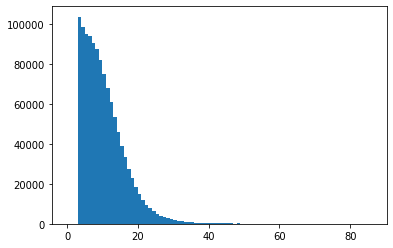

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Show distribution of sentences length in main texts
hist_len = plt.hist(main_sent["sent_len"],bins=max_len, range=(0,max_len))
plt.show()

In [ ]:
#Get relative position of every sentence in its belonging document
main_sent["sent_pos"] = (main_sent.groupby("title",sort=False).cumcount() + 1).astype(float)
main_sent["total_length"] = 0.
main_sent = main_sent.join(main_sent.groupby("title",sort=False)["total_length"].size(), on="title", rsuffix='_r')

main_sent["sent_pos"] = main_sent["sent_pos"] / main_sent["total_length_r"]

main_sent.drop(["total_length","total_length_r"],axis=1,inplace=True)

<ipython-input-54-e8b0b9bc7f99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["sent_pos"] = (main_sent.groupby("title",sort=False).cumcount() + 1).astype(float)
<ipython-input-54-e8b0b9bc7f99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["total_length"] = 0.


In [ ]:
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3,0.020202
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7,0.025253


In [ ]:
main_sent.to_csv("drive/MyDrive/TM&S/data/main_features.csv", index=False)

### Create dataset for Topic Modeling

In [ ]:
# Sentences, after preprocessing, are put back together in order to have clean documents to feed to Topic Models
altrodf = main_sent

altrodf= altrodf.groupby(by="title", sort=False)["sentences"].apply(lambda x: ' '.join(x)).reset_index()

altrodf.head()

,title,sentences
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is..."
1,Bayesian Query Construction for Neural Network...,In this paper we consider the situation wher...
2,"Neural Network Ensembles, Cross Validation, an...",It is well known that a combination of many ...
3,Pulsestream Synapses with Non-Volatile Analogu...,Fusion of the nuclei of hydrogen provides th...
4,Learning to Play the Game of Chess,"Throughout the last decades, the game of ches..."


In [ ]:
altrodf.to_csv("drive/MyDrive/TM&S/data/main_ridotto.csv", index=False)

## Find bigrams and trigrams

In [ ]:
import pandas as pd

main_sent = pd.read_csv("drive/MyDrive/TM&S/data/main_features.csv")
abs_sent = pd.read_csv("drive/MyDrive/TM&S/data/abs_features.csv")

In [ ]:
from ast import literal_eval

main_sent["clean_sent"] = main_sent["clean_sent"].apply(literal_eval)
abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(literal_eval)

In [ ]:
!pip install --upgrade gensim

import gensim
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load bigrams and trigrams model created in the LDA notebook
bigrams_model = Phrases.load("drive/MyDrive/TM&S/models/bigrams_model.pkl")
trigrams_model = Phrases.load("drive/MyDrive/TM&S/models/trigrams_model.pkl")

In [ ]:
# Substitute bigrams
main_sent["clean_sent_grams"] = bigrams_model[main_sent["clean_sent"]]
abs_sent["clean_sent_grams"] = bigrams_model[abs_sent["clean_sent"]]

In [ ]:
# Substitute trigrams
main_sent["clean_sent_grams"] = bigrams_model[main_sent["clean_sent_grams"]]
abs_sent["clean_sent_grams"] = bigrams_model[abs_sent["clean_sent_grams"]]

In [ ]:
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051,"[let, mapping, given]"
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101,"[finite_infinite, set, another, finite_infinit..."
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152,"[learning, machine, observes, set, pair_sample..."
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3,0.020202,"[mean, cartesian_product]"
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7,0.025253,"[computes, estimate, make, small, estimation_e..."


In [ ]:
abs_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams
0,Self-Organization of Associative Database and ...,An efficient method of self-organizing associ...,"[efficient, method, selforganizing, associativ...",11,0.2,"[efficient, method, selforganizing, associativ..."
1,Self-Organization of Associative Database and ...,The proposed databases can associate any input...,"[proposed, database, associate, input, output]",5,0.4,"[proposed, database, associate, input_output]"
2,Self-Organization of Associative Database and ...,"In the first half part of discussion, an algor...","[first, half, part, discussion, algorithm, sel...",7,0.6,"[first_half, part, discussion, algorithm, self..."
3,Self-Organization of Associative Database and ...,"From an aspect of hardware, it produces a new ...","[aspect, hardware, produce, new, style, neural...",7,0.8,"[aspect, hardware, produce_new, style, neural_..."
4,Self-Organization of Associative Database and ...,"In the latter half part, an applicability to h...","[latter, half, part, applicability, handwritte...",12,1.0,"[latter, half, part, applicability, handwritte..."


In [ ]:
main_sent.to_csv("drive/MyDrive/TM&S/data/main_grams_features.csv", index=False)
abs_sent.to_csv("drive/MyDrive/TM&S/data/abs_grams_features.csv", index=False)

## Topic similarity

In [ ]:
import pandas as pd
from ast import literal_eval

main_sent = pd.read_csv("drive/MyDrive/TM&S/data/main_grams_features.csv")


main_sent["clean_sent"] = main_sent["clean_sent"].apply(literal_eval)
main_sent["clean_sent_grams"] = main_sent["clean_sent_grams"].apply(literal_eval)

In [ ]:
import gensim

# Load LDA model
LDA = gensim.models.LdaModel.load("/content/drive/MyDrive/TM&S/models/lda_10trigrams")

In [ ]:
import gensim.corpora as corpora

#Import dictionary used for LDA
id2word_main =  gensim.utils.SaveLoad.load("drive/MyDrive/TM&S/models/main_bow.pkl")

# Term Document Frequency for every sentence
corpus_main = [id2word_main.doc2bow(text) for text in main_sent["clean_sent_grams"]]

In [ ]:
# Get topics probability for every sentence in the corpus
topics = LDA.get_document_topics(corpus_main,minimum_probability=0)

In [ ]:
topics[1]

[(0, 0.080829635),
 (1, 0.10600426),
 (2, 0.081088275),
 (3, 0.07327901),
 (4, 0.11034008),
 (5, 0.09871563),
 (6, 0.07748632),
 (7, 0.12347073),
 (8, 0.09058568),
 (9, 0.15820037)]

In [ ]:
# Insert new data in the dataframe
main_sent["topics"] = [list(zip(*topics[i]))[1] for i in range(len(topics))]

In [ ]:
# From sentences to clean main texts
altrodf = main_sent
altrodf= altrodf.groupby(by="title", sort=False)["clean_sent_grams"].aggregate(func=sum).reset_index()

# Term Document Frequency for every paper
X = [id2word_main.doc2bow(text) for text in altrodf["clean_sent_grams"]]

# Get topics probability for every paper
doc_topics = LDA.get_document_topics(X,minimum_probability=0)

altrodf["topics"] = [list(zip(*doc_topics[i]))[1] for i in range(len(doc_topics))]

altrodf.head()

,title,clean_sent_grams,topics
0,Self-Organization of Associative Database and ...,"[let, mapping, given, finite_infinite, set, an...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."
1,Bayesian Query Construction for Neural Network...,"[paper_consider, situation, data_collection, c...","(6.318733e-05, 0.29339448, 0.13820426, 5.72847..."
2,"Neural Network Ensembles, Cross Validation, an...","[well_known, combination, many_different, pred...","(0.7627803, 0.0999377, 5.9926042e-05, 5.415482..."
3,Pulsestream Synapses with Non-Volatile Analogu...,"[fusion, nucleus, hydrogen, provides, energy, ...","(3.0070025e-05, 0.92038685, 3.0166242e-05, 0.0..."
4,Learning to Play the Game of Chess,"[throughout, last_decade, game_chess, major, t...","(0.029601334, 5.556049e-05, 4.2501157e-05, 3.8..."


In [ ]:
# Merge the dataframes, so that in every row we have sentence-level and document-level topic representation (easier to compute a distance later)
altrodf.rename(columns = {'topics':'doc_topics'}, inplace = True)
main_sent = main_sent.merge(altrodf[["title","doc_topics"]], how="left", on="title")

In [ ]:
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics,doc_topics
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051,"[let, mapping, given]","(0.02530865, 0.033191103, 0.02538963, 0.022944...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101,"[finite_infinite, set, another, finite_infinit...","(0.080829635, 0.10600426, 0.081088275, 0.07327...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152,"[learning, machine, observes, set, pair_sample...","(0.010663864, 0.013985155, 0.010697986, 0.0096...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3,0.020202,"[mean, cartesian_product]","(0.025395706, 0.033305272, 0.025476966, 0.0230...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7,0.025253,"[computes, estimate, make, small, estimation_e...","(0.015006904, 0.019680848, 0.015054923, 0.0136...","(0.045496676, 0.50505626, 4.1512463e-05, 3.751..."


In [ ]:
import numpy as np

main_sent["topics"] = main_sent["topics"].apply(lambda x: np.asarray(x))
main_sent["doc_topics"] = main_sent["doc_topics"].apply(lambda x: np.asarray(x))

In [ ]:
from scipy.spatial import distance

# Compute Jensen-Shannon distance between the sentence-level and document-level topic distributions
main_sent["topics_sim"] = pd.Series(
    distance.jensenshannon(
        np.vstack(main_sent["topics"]),
        np.vstack(main_sent["doc_topics"]),
        axis=1
    )
)

In [ ]:
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics,doc_topics,topics_sim
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051,"[let, mapping, given]","[0.02530865, 0.033191103, 0.02538963, 0.022944...","[0.045496676, 0.50505626, 4.1512463e-05, 3.751...",0.676909
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101,"[finite_infinite, set, another, finite_infinit...","[0.080829635, 0.10600426, 0.081088275, 0.07327...","[0.045496676, 0.50505626, 4.1512463e-05, 3.751...",0.474625
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152,"[learning, machine, observes, set, pair_sample...","[0.010663864, 0.013985155, 0.010697986, 0.0096...","[0.045496676, 0.50505626, 4.1512463e-05, 3.751...",0.616646
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3,0.020202,"[mean, cartesian_product]","[0.025395706, 0.033305272, 0.025476966, 0.0230...","[0.045496676, 0.50505626, 4.1512463e-05, 3.751...",0.516420
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7,0.025253,"[computes, estimate, make, small, estimation_e...","[0.015006904, 0.019680848, 0.015054923, 0.0136...","[0.045496676, 0.50505626, 4.1512463e-05, 3.751...",0.664286


In [ ]:
# Drop not useful columns
main_sent.drop(["topics","doc_topics"],axis=1,inplace=True)

In [ ]:
main_sent.head(3)

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics_sim
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051,"[let, mapping, given]",0.676909
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101,"[finite_infinite, set, another, finite_infinit...",0.474625
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152,"[learning, machine, observes, set, pair_sample...",0.616646


In [ ]:
main_sent.to_csv("drive/MyDrive/TM&S/data/main_grams_features.csv", index=False)

## ROUGE

In [ ]:
import pandas as pd
from ast import literal_eval

abs_sent = pd.read_csv("drive/MyDrive/TM&S/data/abs_features.csv")

abs_sent["clean_sent"] = abs_sent["clean_sent"].apply(literal_eval)

In [ ]:
#!pip install rouge
from rouge import Rouge

# Given a reference and a text, compute ROUGE-2 Recall for each sentence
# and return also the relative position of the best matching sentence in the reference
def my_rouge(hyps,refs):
  rouges = []

  #hyps and refs are lists of lists
  my_hyps = [" ".join(words) for words in hyps]
  my_refs = [" ".join(words) for words in refs]

  scores = Rouge(metrics=["rouge-2"]).get_scores(my_hyps, my_refs, avg=False)

  for i in range(len(scores)):
    rouges.append(scores[i]["rouge-2"].get("r"))

  return np.max(rouges), np.argmax(rouges)

In [ ]:
from tqdm.auto import tqdm

# Create lists of references (sentences from the abstracts)
refs_list = main_sent[["title"]].join(abs_sent.groupby(by="title")["clean_sent"].apply(list),on="title").drop(["title"],axis=1).squeeze()
refs_pos_list = main_sent[["title"]].join(abs_sent.groupby(by="title")["sent_pos"].apply(list),on="title").drop(["title"],axis=1).squeeze()

# For each sentence in the main text, repeat it for each sentence in the relative reference
# (easier to compute ROUGE-2 later with the my_rouge function)
hyps_list = []
for i in tqdm(range(len(main_sent))):
  hyps_list.append([main_sent["clean_sent"][i]]*len(refs_list[i]))

  0%|          | 0/1178438 [00:00<?, ?it/s]

In [ ]:
main_sent["ROUGE-2"] = 0.
main_sent["summ_pos"] = 0.

for i in tqdm(range(len(main_sent))):

  max_rouge, idx = my_rouge(hyps_list[i],refs_list[i])

  main_sent["ROUGE-2"][i] = max_rouge
  main_sent["summ_pos"][i] = refs_pos_list[i][idx]

  0%|          | 0/1178438 [00:00<?, ?it/s]

<ipython-input-137-c57cbbd46e69>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["ROUGE-2"][i] = max_rouge
<ipython-input-137-c57cbbd46e69>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["summ_pos"][i] = refs_pos_list[i][idx]


In [ ]:
main_sent["summ_pos"][main_sent["ROUGE-2"]==0]=-1

<ipython-input-138-5926ecbf5d20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["summ_pos"][main_sent["ROUGE-2"]==0]=-1


In [ ]:
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics_sim,ROUGE-2,summ_pos
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"[let, mapping, given]",3,0.005051,"[let, mapping, given]",0.676909,0.0,-1.0
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","[finite, infinite, set, another, finite, infin...",7,0.010101,"[finite_infinite, set, another, finite_infinit...",0.474625,0.0,-1.0
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"[learning, machine, observes, set, pair, sampl...",7,0.015152,"[learning, machine, observes, set, pair_sample...",0.616646,0.0,-1.0
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"[mean, cartesian, product]",3,0.020202,"[mean, cartesian_product]",0.516420,0.0,-1.0
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","[computes, estimate, make, small, estimation, ...",7,0.025253,"[computes, estimate, make, small, estimation_e...",0.664286,0.0,-1.0


In [ ]:
main_sent.to_csv("drive/MyDrive/TM&S/data/main_grams_features.csv", index=False)

## TF-IDF weighting

In [ ]:
import pandas as pd
from ast import literal_eval

main_sent = pd.read_csv("drive/MyDrive/TM&S/data/main_grams_features.csv")
main_sent["clean_sent_grams"] = main_sent["clean_sent_grams"].apply(literal_eval)
main_sent.head()

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics_sim,ROUGE-2,summ_pos
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"['let', 'mapping', 'given']",3,0.005051,"[let, mapping, given]",0.676909,0.0,-1.0
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","['finite', 'infinite', 'set', 'another', 'fini...",7,0.010101,"[finite_infinite, set, another, finite_infinit...",0.474625,0.0,-1.0
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"['learning', 'machine', 'observes', 'set', 'pa...",7,0.015152,"[learning, machine, observes, set, pair_sample...",0.616646,0.0,-1.0
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"['mean', 'cartesian', 'product']",3,0.020202,"[mean, cartesian_product]",0.516420,0.0,-1.0
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","['computes', 'estimate', 'make', 'small', 'est...",7,0.025253,"[computes, estimate, make, small, estimation_e...",0.664286,0.0,-1.0


In [ ]:
altrodf = main_sent.copy()

altrodf= altrodf.groupby(by="title", sort=False)["clean_sent_grams"].aggregate(func=sum).reset_index()
altrodf.head()

,title,clean_sent_grams
0,Self-Organization of Associative Database and ...,"[let, mapping, given, finite_infinite, set, an..."
1,Bayesian Query Construction for Neural Network...,"[paper_consider, situation, data_collection, c..."
2,"Neural Network Ensembles, Cross Validation, an...","[well_known, combination, many_different, pred..."
3,Pulsestream Synapses with Non-Volatile Analogu...,"[fusion, nucleus, hydrogen, provides, energy, ..."
4,Learning to Play the Game of Chess,"[throughout, last_decade, game_chess, major, t..."


In [ ]:
# Create corpus for TF-IDF
corpus = [" ".join(words) for words in altrodf["clean_sent_grams"]]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
# DataFrame from sparse matrix (easier to find document-term elements)
tf_idf_df = pd.DataFrame.sparse.from_spmatrix(X, index=altrodf.title, columns=vectorizer.get_feature_names_out())

In [ ]:
tf_idf_df["let"]["Self-Organization of Associative Database and Its Applications"]

0.09587074734413566

In [ ]:
tf_idf_df["mapping"]["Self-Organization of Associative Database and Its Applications"]

0.039095699270556936

In [ ]:
tf_idf_df["given"]["Self-Organization of Associative Database and Its Applications"]

0.01261009742430314

In [ ]:
main_sent["tf_idf"]=0.

# Get TF-IDF weight of words in sentences and compute the average value
from tqdm.auto import tqdm

length = len(main_sent)

for i in tqdm(range(length)):
  tfidfs = []
  title = main_sent["title"][i]
  for term in main_sent["clean_sent_grams"][i]:
    try:
      tfidfs.append( tf_idf_df[term][title] )
    except KeyError:
      tfidfs.append(0)

  main_sent["tf_idf"][i] = np.mean(tfidfs)

  0%|          | 0/1178438 [00:00<?, ?it/s]

<ipython-input-69-71a9b0da481b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_sent["tf_idf"][i] = np.mean(tfidfs)


In [ ]:
main_sent

,title,sentences,clean_sent,sent_len,sent_pos,clean_sent_grams,topics_sim,ROUGE-2,summ_pos,tf_idf
0,Self-Organization of Associative Database and ...,Let a mapping f : X -+ Y be given.,"['let', 'mapping', 'given']",3,0.005051,"[let, mapping, given]",0.676909,0.000000,-1.0,0.049192
1,Self-Organization of Associative Database and ...,"Here, X is a finite or infinite set, and Y is ...","['finite', 'infinite', 'set', 'another', 'fini...",7,0.010101,"[finite_infinite, set, another, finite_infinit...",0.474625,0.000000,-1.0,0.038056
2,Self-Organization of Associative Database and ...,A learning machine observes any set of pairs (...,"['learning', 'machine', 'observes', 'set', 'pa...",7,0.015152,"[learning, machine, observes, set, pair_sample...",0.616646,0.000000,-1.0,0.048948
3,Self-Organization of Associative Database and ...,(X x Y means the Cartesian product of X and Y.),"['mean', 'cartesian', 'product']",3,0.020202,"[mean, cartesian_product]",0.516420,0.000000,-1.0,0.022411
4,Self-Organization of Associative Database and ...,"And, it computes some estimate j : X -+ Y of f...","['computes', 'estimate', 'make', 'small', 'est...",7,0.025253,"[computes, estimate, make, small, estimation_e...",0.664286,0.000000,-1.0,0.034419
...,...,...,...,...,...,...,...,...,...,...
1178433,Correlation and Interpolation Networks for Rea...,A distributed view-based representation is com...,"['distributed', 'viewbased', 'representation',...",16,0.968504,"[distributed, viewbased, representation, compu...",0.520661,0.272727,0.4,0.057450
1178434,Correlation and Interpolation Networks for Rea...,3-D constraints on facial shape are achieved t...,"['constraint', 'facial', 'shape', 'achieved', ...",20,0.976378,"[constraint, facial, shape, achieved, use, ana...",0.696025,0.222222,0.8,0.086652
1178435,Correlation and Interpolation Networks for Rea...,With this framework we have been able to achei...,"['framework', 'able', 'acheive', 'fast', 'robu...",9,0.984252,"[framework, able, acheive, fast_robust, analys...",0.398139,0.100000,0.2,0.059963
1178436,Correlation and Interpolation Networks for Rea...,A modeled face mimics the expression of a user...,"['modeled', 'face', 'mimic', 'expression', 'us...",15,0.992126,"[modeled, face, mimic, expression, user, realt...",0.248271,0.000000,-1.0,0.106063


In [ ]:
main_sent.to_csv("drive/MyDrive/TM&S/data/main_grams_features.csv", index=False)